# 1 - Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import jit, grad
import qcsys as qs
import jax.numpy as jnp


/opt/miniconda3/envs/jax-framework/lib/python3.9/site-packages/qutip/__init__.py:66: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


# 2 - Devices

In [22]:
_, Ec_a, El_a = qs.calculate_lambda_over_four_resonator_zpf(5, 50)

resonator = qs.Resonator.create(
    10,
    {"Ec": Ec_a, "El": El_a},
    N_pre_diag=10,
)

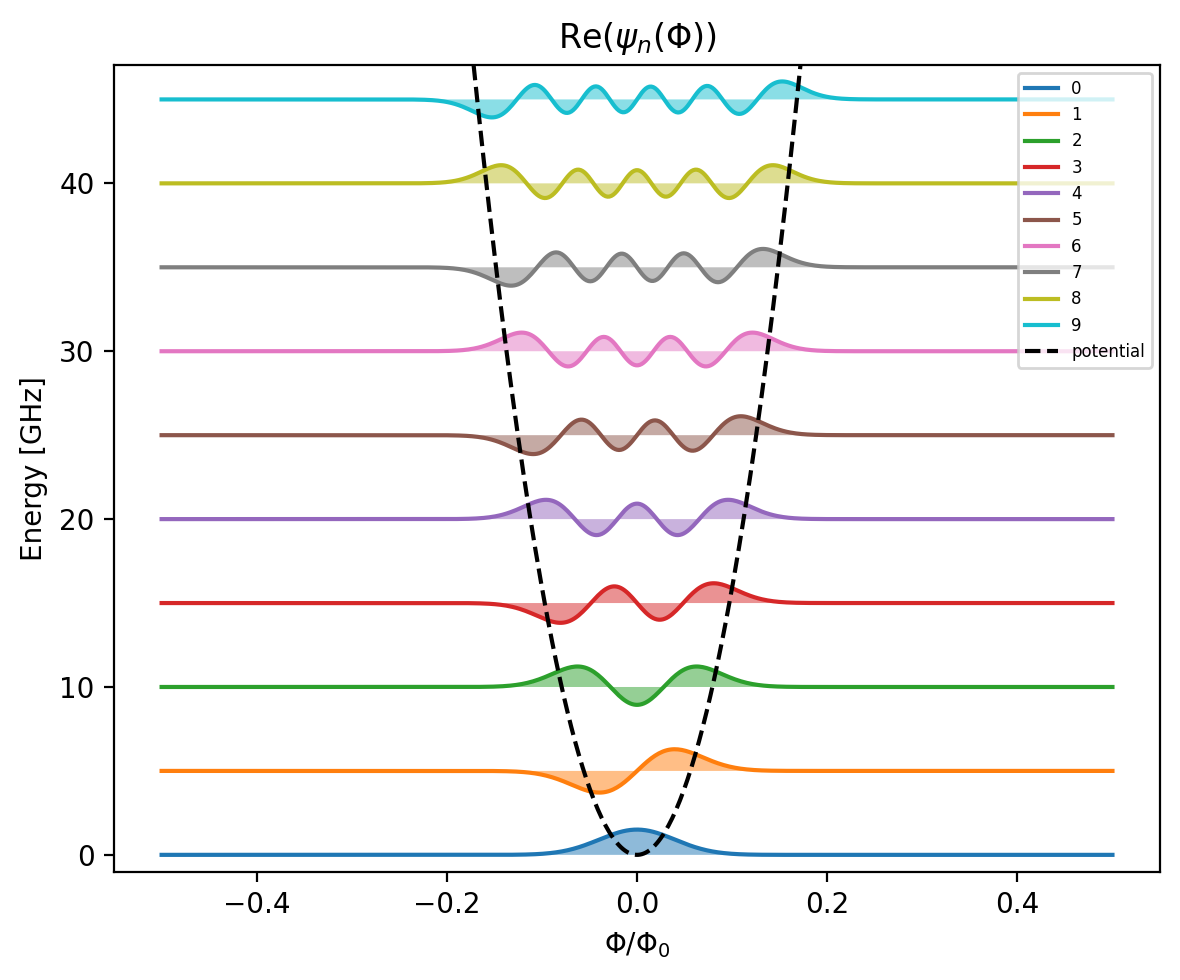

In [24]:
phi_vals = jnp.linspace(-0.5,0.5,500)
axs = resonator.plot_wavefunctions(phi_vals, mode="real")

In [5]:
Ec_q = 1
El_q = 0.5
Ej_q = 8

qubit = qs.Fluxonium.create(
    25,
    {"Ec": Ec_q, "El": El_q, "Ej": Ej_q, "phi_ext": 0.47},
    use_linear=False,
    N_pre_diag=100,
)

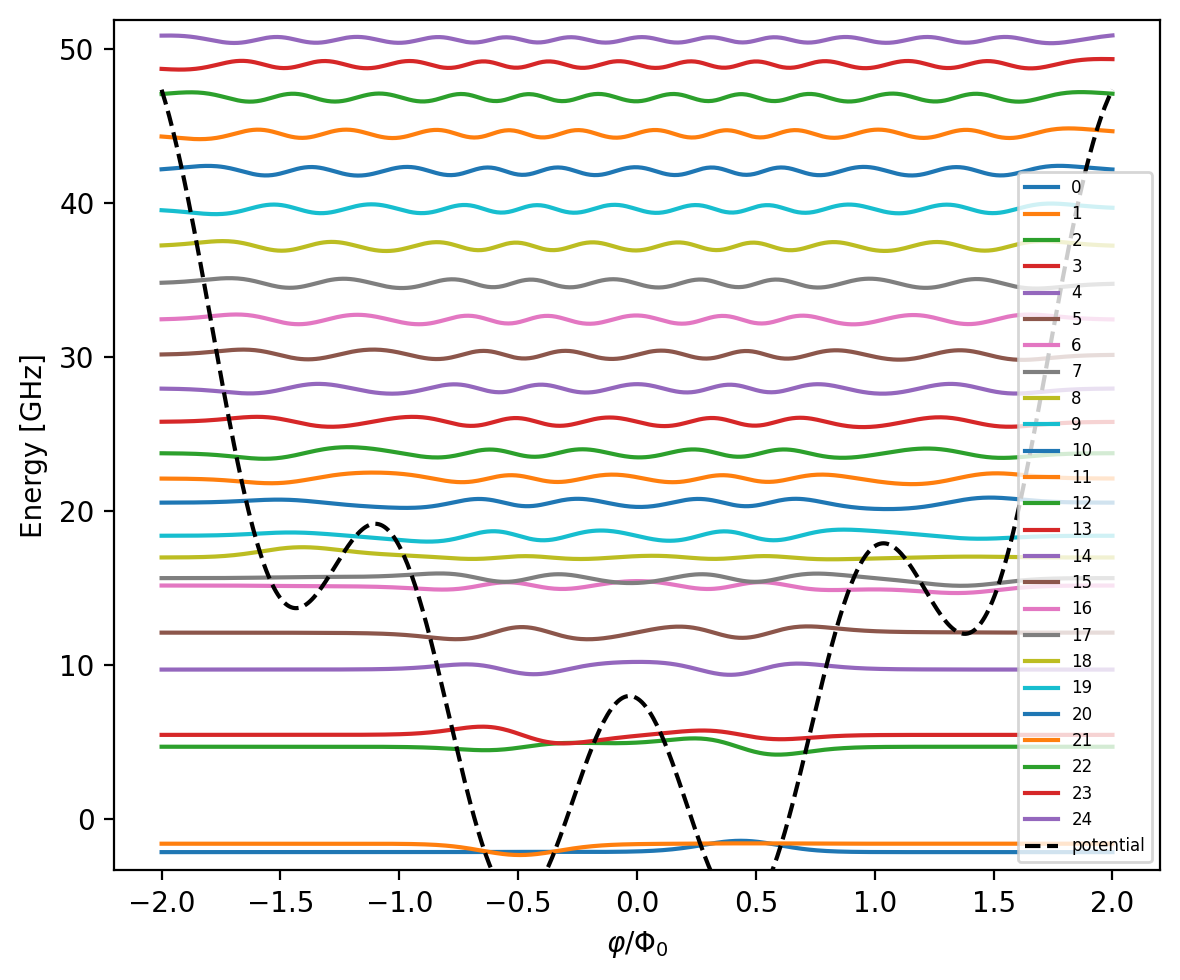

In [6]:
phi_vals = jnp.linspace(-2,2,500)
axs = qubit.plot_wavefunctions(phi_vals)

# 3 - System

In [7]:
g_rq = 0.3

devices = [resonator, qubit]
r_indx = 0
q_indx = 1
Ns = [device.N for device in devices]

a0 = qs.promote(resonator.ops["a"], r_indx, Ns)
a0_dag = qs.promote(resonator.ops["a_dag"], r_indx, Ns)

q0 = qs.promote(qubit.ops["a"], q_indx, Ns)
q0_dag = qs.promote(qubit.ops["a_dag"], q_indx, Ns)

couplings = []
couplings.append(-g_rq * (a0 - a0_dag) @ (q0 - q0_dag))

system = qs.System.create(devices, couplings=couplings)
system.params["g_rq"] = g_rq

In [8]:
Es, kets = system.calculate_eig_linear()

# chi ----
χ_e = Es[1:, 1] - Es[:-1, 1]
χ_g = Es[1:, 0] - Es[:-1, 0]
χ = χ_e - χ_g

# kerr ----
# kerr[0,n] = (E(n+2, g) - E(n+1, g)) - (E(n+1, g) - E(n, g))
# kerr[1,n] = (E(n+2, e) - E(n+1, e)) - (E(n+1, e) - E(n, e))
K_g = (Es[2:, 0] - Es[1:-1, 0]) - (Es[1:-1, 0] - Es[0:-2, 0])
K_e = (Es[2:, 1] - Es[1:-1, 1]) - (Es[1:-1, 1] - Es[0:-2, 1])

χ, K_g, K_e

(Array([-0.00096057, -0.00107511, -0.00087734,  0.01291011, -0.01484728,
        -0.0080187 ,  0.00616372,  0.00394142,  0.00654585], dtype=float64),
 Array([-5.26008728e-04, -3.07609833e-05, -1.62504392e-04,  6.27644810e-04,
        -1.30700981e-03,  3.32534353e-03,  1.72248554e-02,  2.56717879e-01],      dtype=float64),
 Array([-6.40548336e-04,  1.67011919e-04,  1.36249404e-02, -2.71297403e-02,
         5.52157104e-03,  1.75077646e-02,  1.50025483e-02,  2.59322307e-01],      dtype=float64))

In [9]:
Es, kets = system.calculate_eig_linear()

# chi ----
χ_e = Es[1:, 1] - Es[:-1, 1]
χ_g = Es[1:, 0] - Es[:-1, 0]
χ = χ_e - χ_g

# kerr ----
# kerr[0,n] = (E(n+2, g) - E(n+1, g)) - (E(n+1, g) - E(n, g))
# kerr[1,n] = (E(n+2, e) - E(n+1, e)) - (E(n+1, e) - E(n, e))
K_g = (Es[2:, 0] - Es[1:-1, 0]) - (Es[1:-1, 0] - Es[0:-2, 0])
K_e = (Es[2:, 1] - Es[1:-1, 1]) - (Es[1:-1, 1] - Es[0:-2, 1])

χ, K_g, K_e

(Array([-0.00096057, -0.00107511, -0.00087734,  0.01291011, -0.01484728,
        -0.0080187 ,  0.00616372,  0.00394142,  0.00654585], dtype=float64),
 Array([-5.26008728e-04, -3.07609833e-05, -1.62504392e-04,  6.27644810e-04,
        -1.30700981e-03,  3.32534353e-03,  1.72248554e-02,  2.56717879e-01],      dtype=float64),
 Array([-6.40548336e-04,  1.67011919e-04,  1.36249404e-02, -2.71297403e-02,
         5.52157104e-03,  1.75077646e-02,  1.50025483e-02,  2.59322307e-01],      dtype=float64))

# 4 - auto differentiation

In [10]:
@jit
def calculate_metrics(f_r):
    # devices ---

    # Resonator
    _, Ec_a, El_a = qs.calculate_lambda_over_four_resonator_zpf(f_r, 50)

    resonator = qs.Resonator.create(
        10,
        {"Ec": Ec_a, "El": El_a},
        N_pre_diag=10,
    )

    # Fluxonium
    Ec_q = 1
    El_q = 0.5
    Ej_q = 8

    qubit = qs.Fluxonium.create(
        25,
        {"Ec": Ec_q, "El": El_q, "Ej": Ej_q, "phi_ext": 0.47},
        use_linear=False,
        N_pre_diag=100,
    )

    # system ----
    g_rq = 0.3

    devices = [resonator, qubit]
    r_indx = 0
    q_indx = 1
    Ns = [device.N for device in devices]

    a0 = qs.promote(resonator.ops["a"], r_indx, Ns)
    a0_dag = qs.promote(resonator.ops["a_dag"], r_indx, Ns)

    q0 = qs.promote(qubit.ops["a"], q_indx, Ns)
    q0_dag = qs.promote(qubit.ops["a_dag"], q_indx, Ns)

    couplings = []
    couplings.append(-g_rq * (a0 - a0_dag) @ (q0 - q0_dag))

    system = qs.System.create(devices, couplings=couplings)
    system.params["g_rq"] = g_rq

    # metrics ----
    Es, kets = system.calculate_eig_linear()

    # chi
    χ_e = Es[1:, 1] - Es[:-1, 1]
    χ_g = Es[1:, 0] - Es[:-1, 0]
    χ = χ_e - χ_g

    # kerr
    # kerr[0,n] = (E(n+2, g) - E(n+1, g)) - (E(n+1, g) - E(n, g))
    # kerr[1,n] = (E(n+2, e) - E(n+1, e)) - (E(n+1, e) - E(n, e))
    K_g = (Es[2:, 0] - Es[1:-1, 0]) - (Es[1:-1, 0] - Es[0:-2, 0])
    K_e = (Es[2:, 1] - Es[1:-1, 1]) - (Es[1:-1, 1] - Es[0:-2, 1])

    χ, K_g, K_e

    K_avg = (K_g + K_e)/2

    return jnp.abs(χ[0]/K_avg[0])

grad_calculate_metrics = jit(grad(calculate_metrics))

In [11]:
calculate_metrics(3.0)

Array(1.64684707, dtype=float64)

In [12]:
grad_calculate_metrics(4.0)

Array(5.23220617, dtype=float64, weak_type=True)